# Gas Prices in Brazil

> The National Agency of Petroleum, Natural Gas and Bio fuels (ANP in Portuguese) releases weekly reports of gas, diesel and other fuels prices used in transportation across the country. These datasets bring the mean value per liter, number of gas stations analyzed and other information grouped by regions and states across the country.

Source: https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil

In [2]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 500)

In [3]:
df = pd.read_csv("../data/gas-prices-2004-2019.tsv", sep="\t")
df.head()

,Unnamed: 0,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


In [4]:
df["PRODUTO"].unique()

array(['ETANOL HIDRATADO', 'GASOLINA COMUM', 'GLP', 'GNV', 'ÓLEO DIESEL',
       'ÓLEO DIESEL S10'], dtype=object)

In [5]:
df["ESTADO"].unique()

array(['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL',
       'ALAGOAS', 'BAHIA', 'CEARA', 'MARANHAO', 'PARAIBA', 'PERNAMBUCO',
       'PIAUI', 'RIO GRANDE DO NORTE', 'SERGIPE', 'ACRE', 'AMAPA',
       'AMAZONAS', 'PARA', 'RONDONIA', 'RORAIMA', 'TOCANTINS',
       'ESPIRITO SANTO', 'MINAS GERAIS', 'RIO DE JANEIRO', 'SAO PAULO',
       'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA'], dtype=object)

## Framing an example problem
- Predicting the "PREÇO MÉDIO REVENDA"
- On "DATA FINAL"
- Only for the state of São Paulo
- Only for the product "GASOLINA COMUM"

In [7]:
gas_sp = df[(df["PRODUTO"]=="GASOLINA COMUM") & (df["ESTADO"]=="SAO PAULO")][["DATA FINAL", "PREÇO MÉDIO REVENDA"]]

In [9]:
gas_sp["DATA FINAL"] = pd.to_datetime(gas_sp["DATA FINAL"], format="%Y-%m-%d")
gas_sp.head()

,DATA FINAL,PREÇO MÉDIO REVENDA
12087,2004-05-15,1.891
12114,2004-05-22,1.888
12141,2004-05-29,1.894
12168,2004-06-05,1.912
12195,2004-06-12,1.919


In [10]:
gas_sp = (gas_sp
          .reset_index(drop=True)
          .rename(columns={"DATA FINAL": "ds",
                           "PREÇO MÉDIO REVENDA": "y"}))
gas_sp.head()

,ds,y
0,2004-05-15,1.891
1,2004-05-22,1.888
2,2004-05-29,1.894
3,2004-06-05,1.912
4,2004-06-12,1.919


In [11]:
gas_sp.describe()

,y
count,785.000000
mean,2.845648
std,0.609221
min,1.888000
25%,2.411000
50%,2.638000
75%,3.177000
max,4.512000


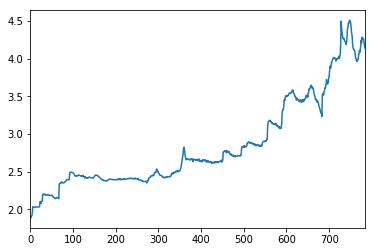

In [12]:
gas_sp["y"].plot()

In [32]:
gas_sp["ds"].describe()

count                     785
unique                    785
top       2013-04-06 00:00:00
freq                        1
first     2004-05-15 00:00:00
last      2019-06-29 00:00:00
Name: ds, dtype: object

We have 15 years of data. This info can be useful for cross validation. We may use 12 years to fit the model and 3 years to validate, or some combination like that.

## Univariate forecast

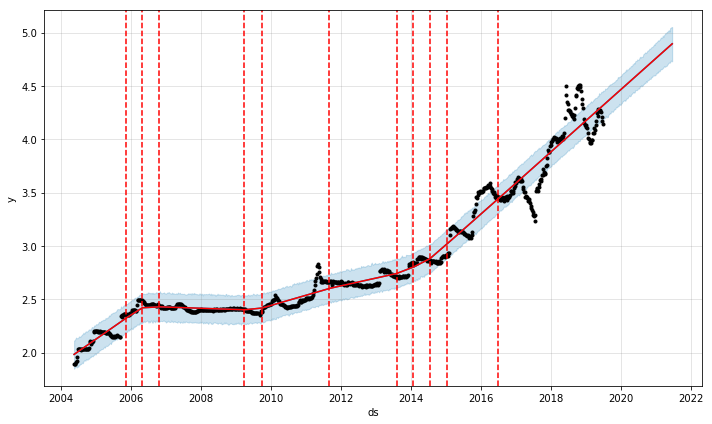

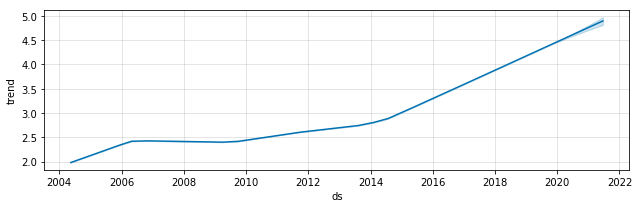

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-06-29 00:00:00 and 2016-06-29 00:00:00


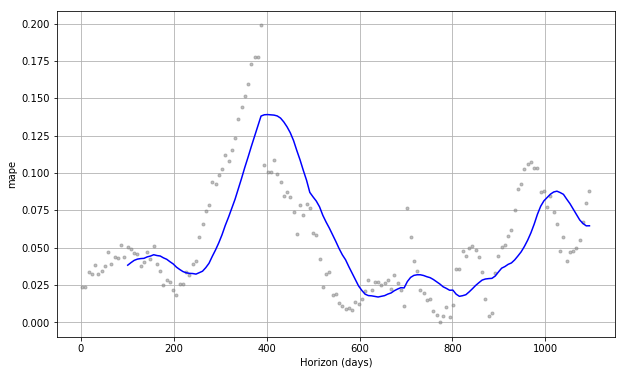

mape: 5.58%


In [48]:
m = Prophet(growth="linear",
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            )
m.fit(gas_sp)

future = m.make_future_dataframe(periods=52*2, freq='W')

forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()
fig2 = m.plot_components(forecast)
plt.show()
df_cv = cross_validation(m, initial='4380 days', period='180 days', horizon = '1095 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

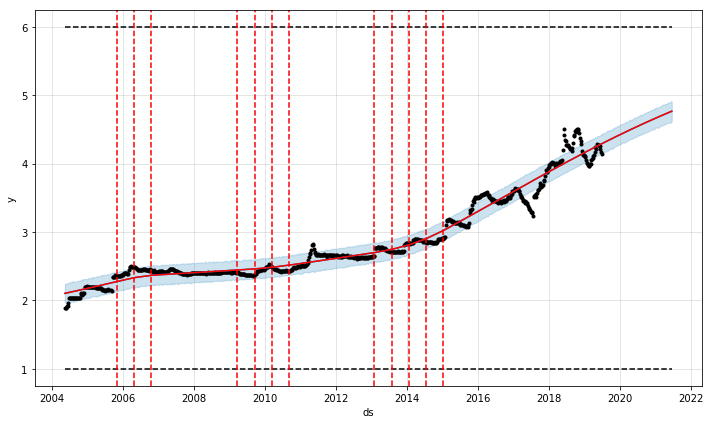

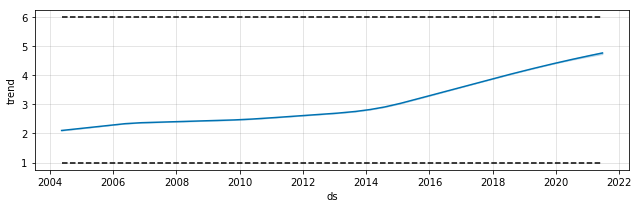

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-06-29 00:00:00 and 2016-06-29 00:00:00


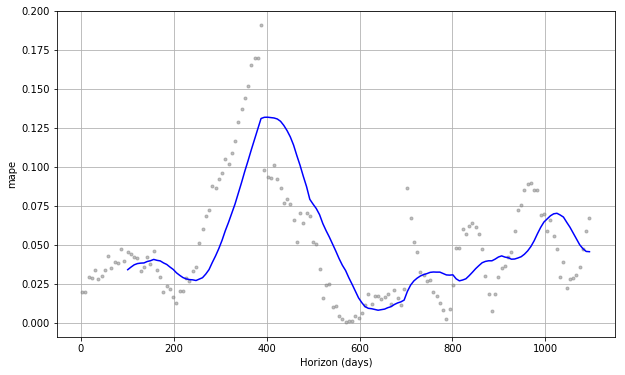

mape: 5.04%


In [47]:
gas_sp_logistic = gas_sp.copy()
gas_sp_logistic["cap"] = 6
gas_sp_logistic["floor"] = 1

m = Prophet(growth="logistic",
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
           )
m.fit(gas_sp_logistic)

future = m.make_future_dataframe(periods=52*2, freq='W')
future["cap"] = 6
future["floor"] = 1

forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()
fig2 = m.plot_components(forecast)
plt.show()
df_cv = cross_validation(m, initial='4380 days', period='180 days', horizon = '1095 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))